### 富士宮焼きそばを食べ歩きしたいのでマップを作った話

PyCon mini Shizuoka 2021

Hiroshi Sano

※なおこのスライドはJupyter + RISEで作成したのでどなたでも動作可能です

- 必要なパッケージをインストールしてください（venvやcondaで仮想環境用意）
    - Google Colabもパッケージを入れればいけると思います
    - pip install requirements.txt
- Plotly+MapBoxを使ったので、Mapboxアカウント作成、API利用登録=>トークンが必要になります
  - .envファイルに`MAPBOX_TOKEN=[token]`を入れてください
- 公開先: https://github.com/hrsano645/fujinomiya-yakisoba-map


## お前誰よ

- 佐野浩士（Hiroshi Sano）[@hrs_sano645](https://twitter.com/hrs_sano645) 🏠:静岡県の富士市🗻
- Job💼
  - [株式会社佐野設計事務所](https://sano-design.info)
    - 自動車系機械の3D設計事務所 
    - 最近では3Dデータのモデリングもしてます
  - 米農家🌾
- Community🧑‍💻
  - 🐍: Python駿河, PyCon mini Shizuokaスタッフ
  - 🐍: PyCon JP 2020 チュートリアル講師
  - 🏙💻: Code for ふじのくに


### みなさんは富士宮焼きそば知ってますよね？

静岡県民多いはずなのでホーム感を感じる😊

<p><a href="https://commons.wikimedia.org/wiki/File:Fujinomiya-yakisoba.jpg#/media/ファイル:Fujinomiya-yakisoba.jpg"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/fc/Fujinomiya-yakisoba.jpg/1200px-Fujinomiya-yakisoba.jpg" alt="Fujinomiya-yakisoba.jpg"></a><br>しんかわな - 投稿者が撮影, <a href="https://creativecommons.org/licenses/by/3.0" title="Creative Commons Attribution 3.0">CC 表示 3.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=5024440">リンク</a>による</p>

## 富士宮焼きそば

- 静岡県富士宮市で生まれた焼きそば。麺が太めで蒸し麺なのが特徴
  - キャベツ、豚の背脂を揚げた肉カスを入れて、ソースとだし粉をかけて食べるのがオーソドックス
- B級グルメの祭典、B-1グランプリ で殿堂入りなのでもはや説明いらないよね
- なお私の地元の富士市でも家庭料理でよく作ります
  - でも麺が別の地域だと手に入らない時がありますね

家で作った焼きそばの様子

<div align="center">
    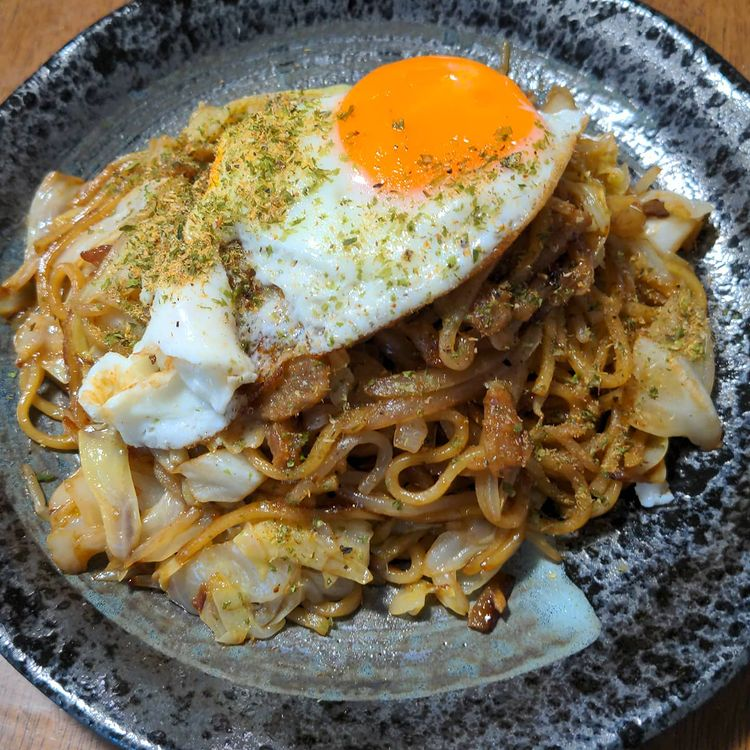
</div>


https://www.instagram.com/p/CRtD4QcpdQn/



## 作り方

- 富士宮焼きそば麺を用意する
- フライパンで油を温める
- キャベツと肉カスを炒める
- 麺を入れる
- 水を入れて少し蒸し焼き
- ウスターソースと醤油を入れる（オイスターソース入れると美味しい）
- 水気を少し飛ばして皿に守る
- だし粉をかけて出来上がり

## 長年作った結果

### はっきりいいってこれ以上美味しい焼きそばは無いと思う

（いわゆるマンネリ化）

家の味に限界を感じる（伸び代がない

ではエンジニアならどうするか...

- 環境を変える: 転職したりしますよね
- 文献をあたる: 技術書を見たり

料理だと

- 環境を変える: **お店で食べ歩きする**
- 文献をあたる: レシピ本を見たり、動画を漁ったり

そうだ、食べ歩きをすればいいのでは🤔

### 富士宮焼きそば食べ歩き計画

そろそろ落ち着いてきてるので落ち着いてきてる時がチャンス

↓

今から下調べしておこう

ということで、今日のテーマです

まず情報源

- [富士宮焼きそば学会](http://www.umya-yakisoba.com)

見てみるとこんな感じ

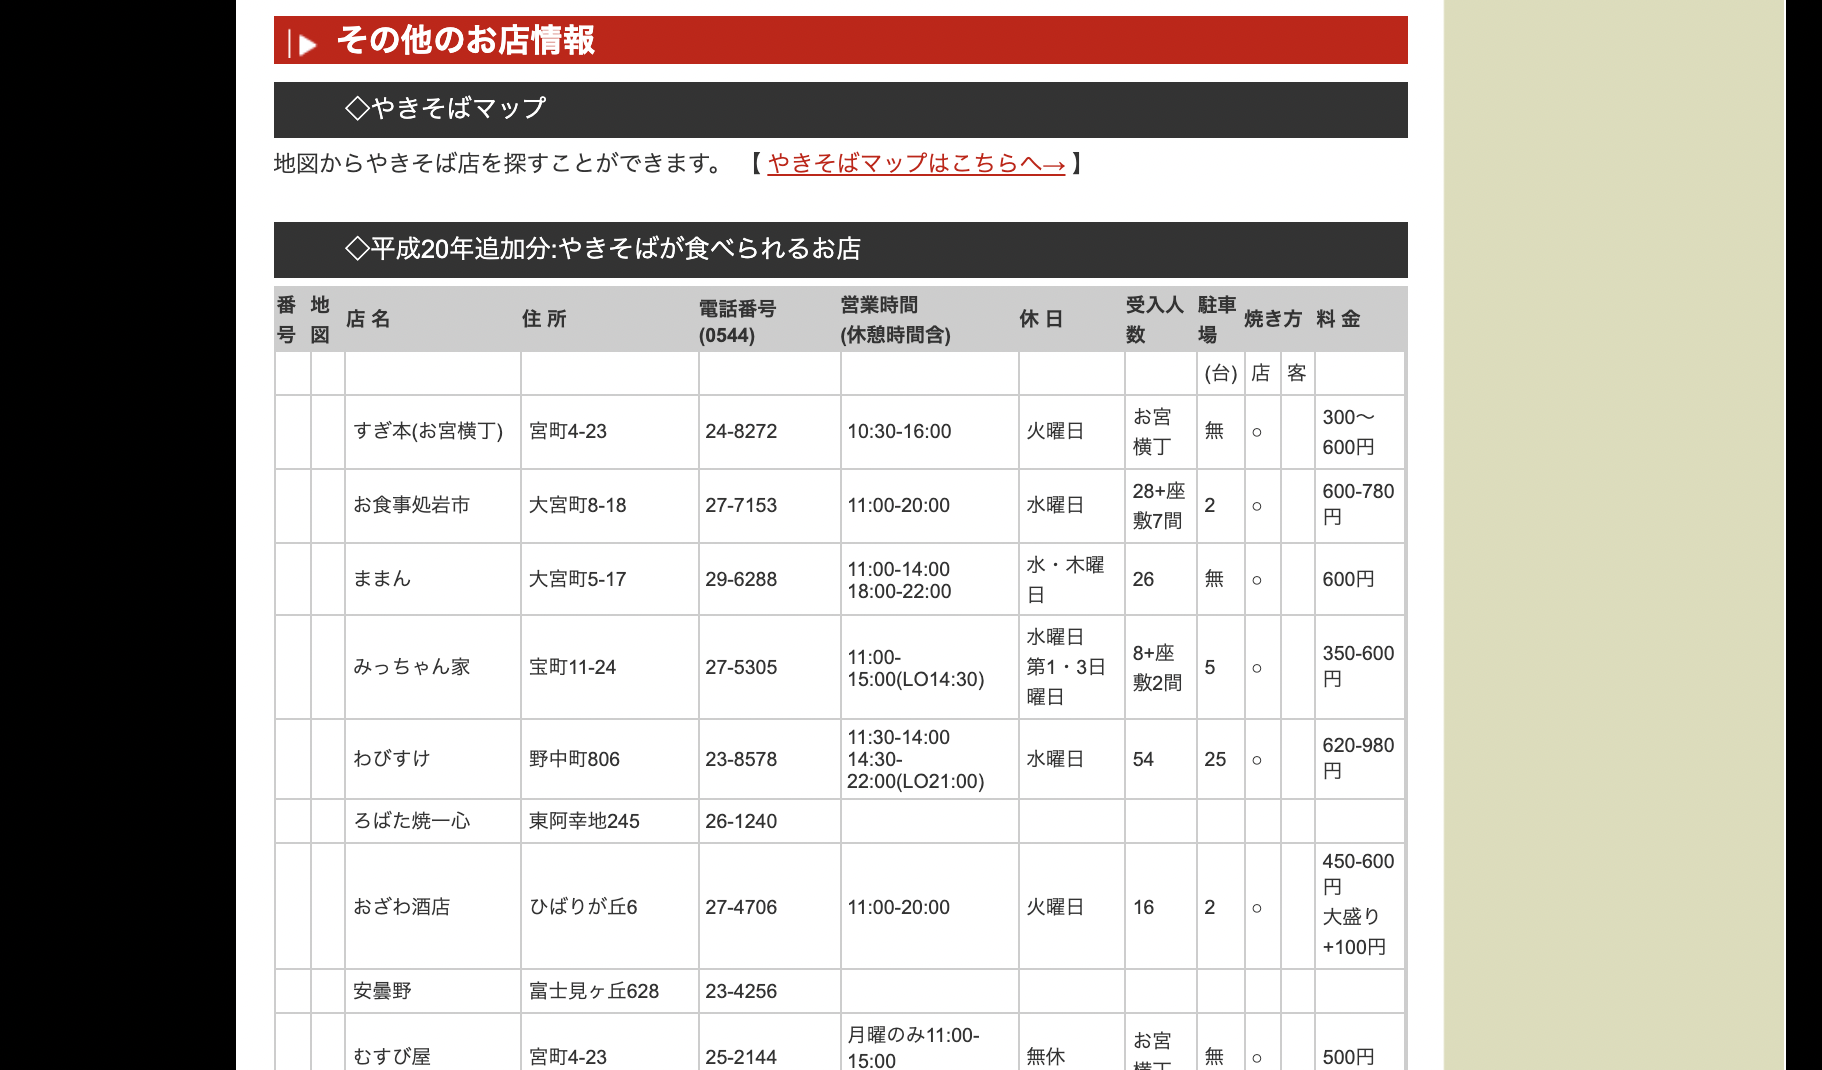



さて、これをどう調理するか。。。


ということでクッキングしていきます。

In [ ]:
# 必要なパッケージ
import json
import os
import random
import time
import urllib.parse

import pandas
import plotly.express as px
import requests
from dotenv import load_dotenv

In [ ]:
# トークン読み込み
# .envにMAPBOX_TOKENを入れてください。
load_dotenv()
mapbox_token = os.environ["MAPBOX_TOKEN"]

In [ ]:
# 焼きそばのリストをとってくる
# http://www.umya-yakisoba.com/contents/taberu/

yakisoba_dfs = pandas.read_html("http://www.umya-yakisoba.com/contents/taberu/")
print(len(yakisoba_dfs))

yakisoba_dfs[2]

In [ ]:
# 最初の二つは別の情報なので除外してます
# 全体を統合して前処理

yakisoba_all = pandas.concat(yakisoba_dfs[2:]).rename(columns={
    "店　名":"店名",
    "住　所":"住所",
    "電話番号（0544）": "電話番号",
    "料 金":"料金",
    "休 日":"休日",
    "焼き方":"焼き方:店",
    "焼き方.1":"焼き方:客"
})
# 必要ない列を除去
yakisoba_all = yakisoba_all.drop(columns=["番号", "地図"])
# 住所がNaNなものを除去
yakisoba_all = yakisoba_all.dropna(subset = ["住所"])
# 店名で重複除去
yakisoba_all = yakisoba_all.drop_duplicates(subset=["店名"])

# インデックスリセット
yakisoba_all = yakisoba_all.reset_index(drop=True)

# 住所に`静岡県富士宮市`を挿入, 電話番号の市外局番をつける
yakisoba_all["住所"] = yakisoba_all["住所"].apply(lambda x: f"静岡県富士宮市{x}")
yakisoba_all["電話番号"] = yakisoba_all["電話番号"].apply(lambda x: f"0544-{x}")


In [14]:
# 富士宮焼きそば学会のお店一覧を作った
yakisoba_all

,Unnamed: 0,店名,住所,電話番号,営業時間（休憩時間含）,休日,受入人数,駐車場,焼き方:店,焼き方:客,料金,lon_lat,lon,lat
0,0,すぎ本（お宮横丁）,静岡県富士宮市宮町4-23,0544-24-8272,10:30-16:00,火曜日,お宮横丁,無,○,NaN,300～600円,"(35.224991, 138.610199)",138.610199,35.224991
1,1,お食事処岩市,静岡県富士宮市大宮町8-18,0544-27-7153,11:00-20:00,水曜日,28＋座敷7間,2,○,NaN,600-780円,"(35.224586, 138.611572)",138.611572,35.224586
2,2,ままん,静岡県富士宮市大宮町5-17,0544-29-6288,11:00-14:0018:00-22:00,水・木曜日,26,無,○,NaN,600円,"(35.22504, 138.611862)",138.611862,35.225040
3,3,みっちゃん家,静岡県富士宮市宝町11-24,0544-27-5305,11:00-15:00(LO14:30),水曜日第１・３日曜日,8＋座敷2間,5,○,NaN,350-600円,"(35.229198, 138.604813)",138.604813,35.229198
4,4,わびすけ,静岡県富士宮市野中町806,0544-23-8578,11:30-14:0014:30-22:00(LO21:00),水曜日,54,25,○,NaN,620-980円,"(35.216354, 138.606567)",138.606567,35.216354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,147,大勝,静岡県富士宮市淀師136-8,0544-27-3968,10:00－20:00,月曜日,25,7,○,NaN,450～700円,"(35.236637, 138.600082)",138.600082,35.236637
148,148,うるおいてい,静岡県富士宮市淀師415-2,0544-24-7155,11:30－14:00,月曜日,50,15,○,○,350～800円,"(35.236973, 138.596466)",138.596466,35.236973
149,149,お好み食堂 伊東,静岡県富士宮市淀師468-2,0544-27-6494,10:30－20:00,月曜、,50,20,○,NaN,350～600円,"(35.240753, 138.596283)",138.596283,35.240753
150,150,しまい,静岡県富士宮市淀師583-20,0544-22-2767,12:00－22:00,日曜日,15,8,○,NaN,350～550円,"(35.238823, 138.599899)",138.599899,35.238823


In [ ]:

yakisoba_all.to_csv("yakisoba_all_tmp.csv",encoding="utf-8")

### 地図にマッピングしてみます

- plotlyのmapbox埋め込み地図にポイント（散布図）を打つグラフで描写してみる
- そのために、住所から緯度経度を出す必要がある
- 今回は国土地理院のAPIを使いました。
  - GeoJsonという位置や道やエリアを定義するJSON形式
  - 国土地理院のサイトにこのAPIの説明が見つけられてない…

In [ ]:
def get_lon_lat(address: str) :
    """
        国土地理院のAPIを使って、
        負荷防止のために、ランダムで問い合わせを行うようにしてます。
        
        returnは(lat, lon) を返す
                
        ref: https://memo.appri.me/programming/gsi-geocoding-api#%E3%82%B8%E3%82%AA%E3%82%B3%E3%83%BC%E3%83%87%E3%82%A3%E3%83%B3%E3%82%B0API
    """

    # 住所文字をURLエンコード
    encoding_address = urllib.parse.quote(address)

    req_api = requests.get(f"https://msearch.gsi.go.jp/address-search/AddressSearch?q={encoding_address}")

    # 結果をprint
    print(f"search:{address} -> {req_api.text}")
    
    # GeoJsonからlon、latをgetする
    req_json = json.loads(req_api.text)
    coordinates = req_json[0]["geometry"]["coordinates"]

    # 問い合わせの時間をランダムでずらす
    time.sleep(random.randint(2,5))

    return (coordinates[1], coordinates[0])

In [ ]:
# このコードは実行すると大体600秒ぐらいかかるので、LT当日は行わないように

# pandasにlon,latを入れる

# copy_yakisoba_all = yakisoba_all.copy()
# yakisoba_all["lon_lat"] = copy_yakisoba_all["住所"].map(lambda x: get_lon_lat(x))
# copy_yakisoba_all = yakisoba_all.copy()
# yakisoba_all["lon"] = copy_yakisoba_all["lon_lat"].map(lambda x: x[1])
# yakisoba_all["lat"] = copy_yakisoba_all["lon_lat"].map(lambda x: x[0])

# INFO:2021-08-26 copyを使うのがやや微妙感あるけど、警告出てたのでそうしました

In [15]:
# 上のセルの実行結果を保存しておいて
# yakisoba_all.to_csv("yakisoba_all_loclat.csv",encoding="utf-8")
# yakisoba_all.to_csv("yakisoba_all_loclat_sjis.csv",encoding="cp932")

# すでにlon、lat入りのcsvファイルで読み込みます

yakisoba_all = pandas.read_csv("yakisoba_all_loclat.csv")

In [16]:
# Plotly + scatter mapboxで地図にポイント
px.set_mapbox_access_token(mapbox_token)

fig = px.scatter_mapbox(yakisoba_all, lat="lat", lon="lon", hover_name="店名",
                zoom=10, title="富士宮焼きそばマップ")
fig.show()

もうちょっときれいにしよう

- ラベルにお店情報が出せるようにする


In [ ]:
fig = px.scatter_mapbox(yakisoba_all, lat="lat", lon="lon", hover_name="店名",
                hover_data=["住所","休日","駐車場","料金"],
                zoom=9, title="富士宮焼きそばマップ")
fig.show()

ここまでのまとめ

- pandas.read_html便利
- 富士宮焼きそばが食べられるお店は中心外以外でもあるが、車がないと行くのが難しい
- mapboxでプロットしたはいいものの、どうやってスマホとかで見ようか悩む

どうやってスマホで見るか🤔

↓

Googleマップに載せたい

Google マイマップでさっきのCSVファイルを取り込む

![googlemymap_yakisoba](./slide_asset/img/googlemymap_yakisoba.png)

Googleマップにもマッピングできた

富士宮に行ったらお店をすぐに探せます😋

### まとめ

富士宮焼きそばはうまいのでぜひ食べよう（県外の人向け）

### まとめ

- pandasを駆使してデータを作ってオープンデータ化するのは面白い
- Plotly強い。便利。
- マップ系の連携とかもうちょっと勉強したい

### もっとやりたかったこと

- 地図のシェープデータで富士宮の地域ごとのお店出現数のコロプレスマップを見たかった
  - ?
- 食べ歩きの最適なルート算出とかしてみたい
  - ?
- GeoPandasとか扱いたかった
  - 位置情報系興味あるので勉強していこうかと

### もっとやりたかったこと

- 地図のシェープデータで富士宮の地域ごとのお店出現数のコロプレスマップを見たかった
  - 細かい地域のシェープデータはなさそうだった（探しきれてないかも）
- 食べ歩きの最適なルート算出とかしてみたい
  - ネットワーク図というかダイクストラを解けば良さそう
  - それするならGoogleマップでやるかな...